# import

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, autograd as ag
import scipy.stats as st
import random
from tqdm import tqdm

from model import *
from dataset import *
from utils import *

In [2]:
hyperparams = {
        'n_tasks': 1000,
        'n_episode': 150,
        'n_timesteps': 10,
        'input_dim': 2, 
        'hidden_dim': 512,
        'output_dim': 2,
        'lr': 1e-4,
        'batch_size': 128,
        'n_epochs': 100,
        }

# Load model

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
def load_model(n_particle=1):
    model = MyModel(input_dim=hyperparams['input_dim'], hidden_dim=hyperparams['hidden_dim'],
                    output_dim=hyperparams['output_dim'], n_particle=n_particle).to(device)
    checkpoint = torch.load('Task1_multiTask.pth.tar', map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

# Load data

In [4]:
dataset = torch.load('./two_links_arm_test')
adapt_data = [data['adapt'] for data in dataset]
test_data = [data['test'] for data in dataset]

In [18]:
adapt_data[0]['angle'][:,0].shape

torch.Size([2])

In [19]:
mask = torch.ones(size=(20,512), dtype=torch.float32, requires_grad=False)

In [30]:
a = torch.rand(size=(1,512))

In [31]:
(a * mask).shape

torch.Size([20, 512])

either one x, multiple mask(multiple particle moving), either a batch of x, one mask(one best particle moving)

# Adaptation 

In [35]:
def smcd(T, N, adapt_data, d=0.05):
    '''
    model: neural network
    T: adaptation timestep
	N: particle numbers
	adapt_data: as name
	d: flip rate
	'''
    model = load_model(n_particle=N)
    q = adapt_data['angle']
    # z = adapt_data['noisy_pos']
    z = adapt_data['true_pos']
    n_features = model.get_dropout_mask().shape[1]
	# initialize M_0
    # M = np.random.randint(low=0,high=2,size=(n_features, N))
    M = np.ones((n_features, N), dtype=np.int8)
    M_best = np.ones(n_features)
    assert T <= q.shape[-1], f'T should be less than {q.shape[-1]}'
    assert not model.training, f'please call model.eval()'
    M_bests = []
    for t in tqdm(range(T)):
        M = flip(M,d)
        M[:,0] = M_best # replace one particle by the last best one (no mutation for the last champion particle)
        # w = []
        model.update_dropout_mask(M.swapaxes(1,0))
        X = model(q[:,t].to(device, dtype=torch.float32)).detach().numpy()
        # for i in range(N):
        #     w_i = st.multivariate_normal.pdf(z[:,t].detach().numpy(), mean=X[i], cov=0.001)
        #     w.append(w_i)
        # to benefit from vectorization we replace p(z_t|x_i) by p(x_i|z_t)
        logW = st.multivariate_normal.logpdf(X, mean=z[:,t].detach().numpy(), cov=0.001)
        W = exp_and_normalise(logW)
        # print(W.shape)
        # print(w)
        # N_eff = int(1 / np.sum((np.asarray(w)) ** 2))
        # print(N_eff)
        if W.sum() != 0: #if w not valid, no update for M_best
            resample_index = resample(range(N), W)
            M = np.take(M, resample_index, axis=1)
            M_best = (M.mean(axis=1) > 0.5).astype(np.int_)
        M_bests.append(M_best)
    return M_bests

In [63]:
def adapt_GD(adapt_data):
    def totorch(x):
        return ag.Variable(torch.FloatTensor(x).to(device))
    
    def train_on_batch(x, y):
        x = totorch(x)
        y = totorch(y)
        optimizer.zero_grad()
        ypred = model.forward(x)
        loss = criterion(ypred, y)
        loss.backward()
        optimizer.step()
        return loss
    
    model = load_model()
    model.train()
    criterion = nn.MSELoss()
    losses = []
    batch_size = 16
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])
    x_train = adapt_data['angle'].to(torch.float32).swapaxes(1,0)
    y_train = adapt_data['noisy_pos'].to(torch.float32).swapaxes(1,0)
    inds = torch.randperm(len(x_train))
    for start in range(0, len(x_train), batch_size):
        mbinds = inds[start:start+batch_size]
        losses.append(train_on_batch(x_train[mbinds], y_train[mbinds]).item())
    return np.mean(losses)

In [61]:
def compare_adaptation(adapt_timestep=10, n_particles=300):
    losses = []
    losses_no_adapt = []
    losses_GD = []
    criterion = nn.MSELoss()
    M_best_per_task = []
    for i in range(len(adapt_data)):
        model = load_model()
        q = adapt_data[i]['angle'].to(torch.float32).swapaxes(1,0)
        x = adapt_data[i]['true_pos'].to(torch.float32).swapaxes(1,0)
        x_noadapt = model(q).detach()
        loss_GD = adapt_GD(adapt_data[i])
        
        M_best = smcd(adapt_timestep, n_particles, adapt_data[i], d=0.15)
        M_best_per_task.append(M_best[-1].reshape(1,-1))
        model.update_dropout_mask(M_best[-1].reshape(1,-1))
        x_pred = model(q).detach()
        
        loss = criterion(x_pred, x)
        loss_no_adapt = criterion(x_noadapt, x)
        # print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, limb length is {dataset.l[i]}")
        # print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, No adaptation loss is {round(loss_no_adapt.item(), 3)}, limb length is {dataset.l[i]}")
        print(f"For {i}th task, loss with SMCD is {round(loss.item(), 3)}, "
          f"loss with GD is {round(loss_GD, 3)}, "
          f"loss wto adaptation is {round(loss_no_adapt.item(), 3)}.")
        losses.append(loss)
        losses_no_adapt.append(loss_no_adapt)
        losses_GD.append(loss_GD)
    return losses, losses_no_adapt, losses_GD, M_best_per_task

In [64]:
losses, losses_no_adapt, losses_GD, M_best_per_task = compare_adaptation(100, 1000)

100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


For 0th task, loss with SMCD is 1.59, loss with GD is 1.59, loss wto adaptation is 1.522.


100%|██████████| 100/100 [00:03<00:00, 33.24it/s]


For 1th task, loss with SMCD is 0.759, loss with GD is 0.83, loss wto adaptation is 0.823.


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


For 2th task, loss with SMCD is 0.408, loss with GD is 0.662, loss wto adaptation is 0.629.


100%|██████████| 100/100 [00:02<00:00, 36.23it/s]


For 3th task, loss with SMCD is 0.096, loss with GD is 0.405, loss wto adaptation is 0.454.


100%|██████████| 100/100 [00:02<00:00, 37.20it/s]


For 4th task, loss with SMCD is 1.89, loss with GD is 1.976, loss wto adaptation is 2.0.


100%|██████████| 100/100 [00:02<00:00, 36.92it/s]


For 5th task, loss with SMCD is 1.249, loss with GD is 1.319, loss wto adaptation is 1.34.


100%|██████████| 100/100 [00:03<00:00, 33.12it/s]


For 6th task, loss with SMCD is 0.679, loss with GD is 0.92, loss wto adaptation is 0.913.


100%|██████████| 100/100 [00:02<00:00, 37.45it/s]


For 7th task, loss with SMCD is 1.062, loss with GD is 1.113, loss wto adaptation is 1.172.


100%|██████████| 100/100 [00:02<00:00, 36.07it/s]


For 8th task, loss with SMCD is 0.473, loss with GD is 0.726, loss wto adaptation is 0.784.


100%|██████████| 100/100 [00:02<00:00, 36.36it/s]


For 9th task, loss with SMCD is 0.247, loss with GD is 0.431, loss wto adaptation is 0.398.


100%|██████████| 100/100 [00:02<00:00, 34.87it/s]


For 10th task, loss with SMCD is 0.872, loss with GD is 0.867, loss wto adaptation is 0.88.


100%|██████████| 100/100 [00:02<00:00, 35.03it/s]


For 11th task, loss with SMCD is 0.909, loss with GD is 1.051, loss wto adaptation is 1.023.


100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


For 12th task, loss with SMCD is 1.059, loss with GD is 1.051, loss wto adaptation is 1.131.


100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


For 13th task, loss with SMCD is 0.795, loss with GD is 0.894, loss wto adaptation is 0.923.


100%|██████████| 100/100 [00:02<00:00, 35.04it/s]


For 14th task, loss with SMCD is 0.443, loss with GD is 0.749, loss wto adaptation is 0.783.


100%|██████████| 100/100 [00:02<00:00, 36.40it/s]


For 15th task, loss with SMCD is 0.596, loss with GD is 0.773, loss wto adaptation is 0.722.


100%|██████████| 100/100 [00:03<00:00, 32.76it/s]


For 16th task, loss with SMCD is 0.903, loss with GD is 0.914, loss wto adaptation is 0.973.


100%|██████████| 100/100 [00:02<00:00, 35.29it/s]


For 17th task, loss with SMCD is 1.157, loss with GD is 1.354, loss wto adaptation is 1.278.


100%|██████████| 100/100 [00:02<00:00, 33.95it/s]


For 18th task, loss with SMCD is 0.966, loss with GD is 1.075, loss wto adaptation is 1.021.


100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


For 19th task, loss with SMCD is 1.614, loss with GD is 1.571, loss wto adaptation is 1.573.


100%|██████████| 100/100 [00:02<00:00, 35.98it/s]


For 20th task, loss with SMCD is 0.982, loss with GD is 0.983, loss wto adaptation is 1.053.


100%|██████████| 100/100 [00:03<00:00, 31.25it/s]


For 21th task, loss with SMCD is 0.898, loss with GD is 1.074, loss wto adaptation is 1.111.


100%|██████████| 100/100 [00:03<00:00, 32.96it/s]


For 22th task, loss with SMCD is 0.876, loss with GD is 1.208, loss wto adaptation is 1.261.


100%|██████████| 100/100 [00:02<00:00, 34.69it/s]


For 23th task, loss with SMCD is 0.777, loss with GD is 0.964, loss wto adaptation is 0.965.


100%|██████████| 100/100 [00:02<00:00, 34.81it/s]


For 24th task, loss with SMCD is 0.743, loss with GD is 0.991, loss wto adaptation is 0.867.


100%|██████████| 100/100 [00:02<00:00, 35.51it/s]


For 25th task, loss with SMCD is 1.117, loss with GD is 1.143, loss wto adaptation is 1.122.


100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


For 26th task, loss with SMCD is 0.952, loss with GD is 1.384, loss wto adaptation is 1.325.


100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


For 27th task, loss with SMCD is 0.566, loss with GD is 0.938, loss wto adaptation is 1.028.


100%|██████████| 100/100 [00:02<00:00, 39.07it/s]


For 28th task, loss with SMCD is 0.745, loss with GD is 0.829, loss wto adaptation is 0.855.


100%|██████████| 100/100 [00:02<00:00, 36.27it/s]


For 29th task, loss with SMCD is 1.177, loss with GD is 1.136, loss wto adaptation is 1.172.


100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


For 30th task, loss with SMCD is 0.623, loss with GD is 0.841, loss wto adaptation is 0.818.


100%|██████████| 100/100 [00:02<00:00, 37.33it/s]


For 31th task, loss with SMCD is 1.364, loss with GD is 1.444, loss wto adaptation is 1.431.


100%|██████████| 100/100 [00:02<00:00, 40.45it/s]


For 32th task, loss with SMCD is 0.901, loss with GD is 0.963, loss wto adaptation is 0.92.


100%|██████████| 100/100 [00:02<00:00, 36.82it/s]


For 33th task, loss with SMCD is 0.969, loss with GD is 1.315, loss wto adaptation is 1.302.


100%|██████████| 100/100 [00:02<00:00, 40.16it/s]


For 34th task, loss with SMCD is 0.749, loss with GD is 0.939, loss wto adaptation is 0.858.


100%|██████████| 100/100 [00:02<00:00, 38.55it/s]


For 35th task, loss with SMCD is 1.347, loss with GD is 1.452, loss wto adaptation is 1.374.


100%|██████████| 100/100 [00:02<00:00, 38.60it/s]


For 36th task, loss with SMCD is 1.858, loss with GD is 1.769, loss wto adaptation is 1.736.


100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


For 37th task, loss with SMCD is 1.714, loss with GD is 1.778, loss wto adaptation is 1.797.


100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


For 38th task, loss with SMCD is 0.806, loss with GD is 0.991, loss wto adaptation is 0.96.


100%|██████████| 100/100 [00:02<00:00, 40.37it/s]


For 39th task, loss with SMCD is 0.669, loss with GD is 0.698, loss wto adaptation is 0.718.


100%|██████████| 100/100 [00:02<00:00, 37.42it/s]


For 40th task, loss with SMCD is 0.701, loss with GD is 0.917, loss wto adaptation is 0.955.


100%|██████████| 100/100 [00:02<00:00, 39.76it/s]


For 41th task, loss with SMCD is 1.281, loss with GD is 1.405, loss wto adaptation is 1.423.


100%|██████████| 100/100 [00:02<00:00, 37.10it/s]


For 42th task, loss with SMCD is 0.65, loss with GD is 0.726, loss wto adaptation is 0.703.


100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


For 43th task, loss with SMCD is 1.032, loss with GD is 1.065, loss wto adaptation is 1.1.


100%|██████████| 100/100 [00:02<00:00, 37.20it/s]


For 44th task, loss with SMCD is 0.675, loss with GD is 0.805, loss wto adaptation is 0.825.


100%|██████████| 100/100 [00:02<00:00, 38.77it/s]


For 45th task, loss with SMCD is 1.849, loss with GD is 1.911, loss wto adaptation is 1.904.


100%|██████████| 100/100 [00:02<00:00, 38.87it/s]


For 46th task, loss with SMCD is 0.734, loss with GD is 1.017, loss wto adaptation is 1.025.


100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


For 47th task, loss with SMCD is 0.896, loss with GD is 0.936, loss wto adaptation is 0.913.


100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


For 48th task, loss with SMCD is 1.148, loss with GD is 1.181, loss wto adaptation is 1.233.


100%|██████████| 100/100 [00:03<00:00, 32.34it/s]


For 49th task, loss with SMCD is 0.796, loss with GD is 0.995, loss wto adaptation is 1.015.


100%|██████████| 100/100 [00:02<00:00, 37.33it/s]


For 50th task, loss with SMCD is 1.398, loss with GD is 1.378, loss wto adaptation is 1.393.


100%|██████████| 100/100 [00:02<00:00, 36.49it/s]


For 51th task, loss with SMCD is 0.522, loss with GD is 0.843, loss wto adaptation is 0.831.


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


For 52th task, loss with SMCD is 1.065, loss with GD is 1.251, loss wto adaptation is 1.227.


100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


For 53th task, loss with SMCD is 1.595, loss with GD is 1.485, loss wto adaptation is 1.587.


100%|██████████| 100/100 [00:02<00:00, 35.52it/s]


For 54th task, loss with SMCD is 0.4, loss with GD is 0.644, loss wto adaptation is 0.782.


100%|██████████| 100/100 [00:02<00:00, 36.36it/s]


For 55th task, loss with SMCD is 1.001, loss with GD is 1.073, loss wto adaptation is 1.016.


100%|██████████| 100/100 [00:02<00:00, 36.20it/s]


For 56th task, loss with SMCD is 0.982, loss with GD is 1.12, loss wto adaptation is 1.106.


100%|██████████| 100/100 [00:02<00:00, 36.04it/s]


For 57th task, loss with SMCD is 1.543, loss with GD is 1.486, loss wto adaptation is 1.498.


100%|██████████| 100/100 [00:02<00:00, 35.31it/s]


For 58th task, loss with SMCD is 1.008, loss with GD is 1.106, loss wto adaptation is 1.059.


100%|██████████| 100/100 [00:02<00:00, 34.81it/s]


For 59th task, loss with SMCD is 0.39, loss with GD is 0.626, loss wto adaptation is 0.631.


100%|██████████| 100/100 [00:02<00:00, 35.79it/s]


For 60th task, loss with SMCD is 1.048, loss with GD is 1.161, loss wto adaptation is 1.126.


100%|██████████| 100/100 [00:02<00:00, 34.77it/s]


For 61th task, loss with SMCD is 0.993, loss with GD is 1.076, loss wto adaptation is 1.056.


100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


For 62th task, loss with SMCD is 0.594, loss with GD is 0.761, loss wto adaptation is 0.763.


100%|██████████| 100/100 [00:02<00:00, 35.66it/s]


For 63th task, loss with SMCD is 1.681, loss with GD is 1.661, loss wto adaptation is 1.671.


100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


For 64th task, loss with SMCD is 1.028, loss with GD is 1.143, loss wto adaptation is 1.091.


100%|██████████| 100/100 [00:02<00:00, 35.52it/s]


For 65th task, loss with SMCD is 0.884, loss with GD is 0.92, loss wto adaptation is 0.912.


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


For 66th task, loss with SMCD is 0.717, loss with GD is 0.715, loss wto adaptation is 0.788.


100%|██████████| 100/100 [00:02<00:00, 35.53it/s]


For 67th task, loss with SMCD is 1.079, loss with GD is 1.147, loss wto adaptation is 1.087.


100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


For 68th task, loss with SMCD is 0.316, loss with GD is 0.519, loss wto adaptation is 0.548.


100%|██████████| 100/100 [00:02<00:00, 35.37it/s]


For 69th task, loss with SMCD is 0.438, loss with GD is 0.932, loss wto adaptation is 0.886.


100%|██████████| 100/100 [00:02<00:00, 33.96it/s]


For 70th task, loss with SMCD is 1.147, loss with GD is 1.343, loss wto adaptation is 1.439.


100%|██████████| 100/100 [00:02<00:00, 35.17it/s]


For 71th task, loss with SMCD is 1.001, loss with GD is 1.077, loss wto adaptation is 1.061.


100%|██████████| 100/100 [00:02<00:00, 34.80it/s]


For 72th task, loss with SMCD is 0.993, loss with GD is 1.253, loss wto adaptation is 1.268.


100%|██████████| 100/100 [00:02<00:00, 35.09it/s]


For 73th task, loss with SMCD is 0.427, loss with GD is 0.646, loss wto adaptation is 0.643.


100%|██████████| 100/100 [00:02<00:00, 34.33it/s]


For 74th task, loss with SMCD is 1.705, loss with GD is 1.911, loss wto adaptation is 1.944.


100%|██████████| 100/100 [00:02<00:00, 35.10it/s]


For 75th task, loss with SMCD is 0.602, loss with GD is 0.722, loss wto adaptation is 0.735.


100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


For 76th task, loss with SMCD is 0.367, loss with GD is 0.565, loss wto adaptation is 0.622.


100%|██████████| 100/100 [00:02<00:00, 36.22it/s]


For 77th task, loss with SMCD is 2.122, loss with GD is 2.174, loss wto adaptation is 2.159.


100%|██████████| 100/100 [00:02<00:00, 36.64it/s]


For 78th task, loss with SMCD is 0.408, loss with GD is 0.729, loss wto adaptation is 0.682.


100%|██████████| 100/100 [00:02<00:00, 36.36it/s]


For 79th task, loss with SMCD is 1.019, loss with GD is 1.38, loss wto adaptation is 1.31.


100%|██████████| 100/100 [00:02<00:00, 37.78it/s]


For 80th task, loss with SMCD is 0.569, loss with GD is 0.7, loss wto adaptation is 0.682.


100%|██████████| 100/100 [00:02<00:00, 36.34it/s]


For 81th task, loss with SMCD is 1.201, loss with GD is 1.294, loss wto adaptation is 1.307.


100%|██████████| 100/100 [00:02<00:00, 36.55it/s]


For 82th task, loss with SMCD is 1.278, loss with GD is 1.336, loss wto adaptation is 1.364.


100%|██████████| 100/100 [00:02<00:00, 37.13it/s]


For 83th task, loss with SMCD is 0.626, loss with GD is 0.772, loss wto adaptation is 0.787.


100%|██████████| 100/100 [00:02<00:00, 36.37it/s]


For 84th task, loss with SMCD is 0.688, loss with GD is 0.812, loss wto adaptation is 0.739.


100%|██████████| 100/100 [00:02<00:00, 36.83it/s]


For 85th task, loss with SMCD is 1.031, loss with GD is 1.109, loss wto adaptation is 1.077.


100%|██████████| 100/100 [00:02<00:00, 35.91it/s]


For 86th task, loss with SMCD is 0.425, loss with GD is 0.709, loss wto adaptation is 0.673.


100%|██████████| 100/100 [00:02<00:00, 37.32it/s]


For 87th task, loss with SMCD is 0.865, loss with GD is 1.155, loss wto adaptation is 1.124.


100%|██████████| 100/100 [00:02<00:00, 36.27it/s]


For 88th task, loss with SMCD is 0.672, loss with GD is 0.815, loss wto adaptation is 0.814.


100%|██████████| 100/100 [00:03<00:00, 31.42it/s]


For 89th task, loss with SMCD is 0.902, loss with GD is 1.097, loss wto adaptation is 1.067.


100%|██████████| 100/100 [00:03<00:00, 32.19it/s]


For 90th task, loss with SMCD is 1.02, loss with GD is 1.141, loss wto adaptation is 1.146.


100%|██████████| 100/100 [00:02<00:00, 34.09it/s]


For 91th task, loss with SMCD is 1.214, loss with GD is 1.366, loss wto adaptation is 1.408.


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


For 92th task, loss with SMCD is 0.809, loss with GD is 0.995, loss wto adaptation is 0.986.


100%|██████████| 100/100 [00:02<00:00, 35.06it/s]


For 93th task, loss with SMCD is 0.453, loss with GD is 0.525, loss wto adaptation is 0.556.


100%|██████████| 100/100 [00:02<00:00, 34.07it/s]


For 94th task, loss with SMCD is 1.237, loss with GD is 1.204, loss wto adaptation is 1.138.


100%|██████████| 100/100 [00:02<00:00, 34.98it/s]


For 95th task, loss with SMCD is 0.392, loss with GD is 0.609, loss wto adaptation is 0.582.


100%|██████████| 100/100 [00:02<00:00, 35.10it/s]


For 96th task, loss with SMCD is 1.081, loss with GD is 1.197, loss wto adaptation is 1.183.


100%|██████████| 100/100 [00:02<00:00, 33.82it/s]


For 97th task, loss with SMCD is 0.266, loss with GD is 0.59, loss wto adaptation is 0.563.


100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


For 98th task, loss with SMCD is 0.769, loss with GD is 1.051, loss wto adaptation is 0.98.


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


For 99th task, loss with SMCD is 1.985, loss with GD is 1.942, loss wto adaptation is 1.958.


In [25]:
np.save('loss_smcd',losses)
np.save('loss_N',losses_no_adapt)
np.save('loss_GD',losses_GD)

In [36]:
def repeat_smcd(n_repeat=10, adapt_timestep=10, n_particles=300):
    l_losses = []
    for _ in range(n_repeat):
        losses = []
        criterion = nn.MSELoss()
        for i in range(len(adapt_data)):
            q = adapt_data[i]['angle'].to(torch.float32).swapaxes(1,0)
            x = adapt_data[i]['true_pos'].to(torch.float32).swapaxes(1,0)
            M_best = smcd(adapt_timestep, n_particles, adapt_data[i], d=0.15)
            model = load_model()
            model.update_dropout_mask(M_best[-1].reshape(1,-1))
            x_pred = model(q).detach()
            loss = criterion(x_pred, x)

            losses.append(loss.item())
        l_losses.append(losses)
    return l_losses

In [37]:
l_losses = repeat_smcd(10, 100, 1000)
np.save('./losses_smcd_repeated.npy', l_losses)

100%|██████████| 100/100 [00:03<00:00, 32.76it/s]


# Prediction

In [38]:
test_data[0].keys()

dict_keys(['init_angle', 'init_pos', 'target_pos', 'true_pos', 'noisy_pos'])

In [39]:
def plot_trace(t, start=0, end=-1):
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='true_pos')
	plt.legend()

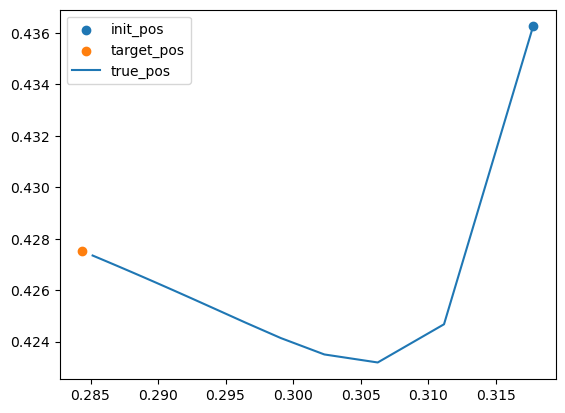

In [55]:
plot_trace(test_data[8], 0, 20)

In [134]:
def test_smcd(mask_per_task, n_tasks = 100):
	trace_pred = []
	trace_true = []
	criterion = nn.MSELoss()
	with tqdm(test_data[0:n_tasks], unit='task')as tepoch:
		for i, task in enumerate(tepoch):
			trace_pred_i = np.array([])
			trace_true_i = np.array([])
			model = load_model()
			q0 = task['init_angle'].to(dtype=torch.float32)
			xg = task['target_pos']
			x_oracle = task['true_pos']
			model.update_dropout_mask(mask_per_task[i])
			q = q0
			u = np.zeros_like(q)
			l = dataset.l[i]
			# x0 = task['init_pos']
			# x0_pred = model(q0)
			# loss = criterion(x0_pred, x0)
			# print(loss)
			for t in range(len(x_oracle)):
				x_pred = model(q).detach()
				x_true = fk(q, l)
				# emit control from predicted position
				u = pd(q.squeeze(), x_pred.squeeze(), xg, u.squeeze(), k=[1,1e-3], l=l)
				q += u
				# normalize
				q = np.mod(q, 2 * np.pi)
				q[q>np.pi] -= 2*np.pi
				# the system evolve subject to control and real setting
				# print(x_pred)
				# print(x_true)
				trace_pred_i = np.append(trace_pred_i, x_pred.squeeze().numpy(), axis=0)
				trace_true_i = np.append(trace_true_i, x_true, axis=0)
			trace_pred.append(trace_pred_i.reshape(-1,2))
			trace_true.append(trace_true_i.reshape(-1,2))
	return trace_pred, trace_true


In [135]:
trace_pred, trace_true = test_smcd(M_best_per_task)

100%|██████████| 100/100 [00:43<00:00,  2.28task/s]


In [186]:
def plot_trace(i, start=0, end=-1):
	t = test_data[i]
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos', c='tab:grey')
	plt.scatter(*trace_pred[i][start], marker='o', label='init_pos_pred', c='tab:orange')
	plt.scatter(*target_pos, label='target_pos', marker='^', c='tab:green')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='oracle_trace', c='tab:grey')
	plt.plot(trace_true[i][start:end,0], trace_true[i][start:end,1], label='true_trace', c='tab:blue')
	plt.plot(trace_pred[i][start:end,0], trace_pred[i][start:end,1], label='pred_trace', c='tab:orange')
	plt.legend()

In [143]:
def compute_loss(trace_true, trace_oracle):
	losses = []
	criterion = nn.MSELoss()
	for true, oracle in zip(trace_true, trace_oracle):
		losses.append(criterion(true, oracle))
	return losses

In [147]:
trace_oracle = [data['true_pos'].numpy() for data in test_data]

In [187]:
len(trace_true), len(trace_oracle)
trace_oracle[0].shape, trace_true[0].shape

((200, 2), (200, 2))

In [ ]:
compute_loss(trace_true, trace_oracle)

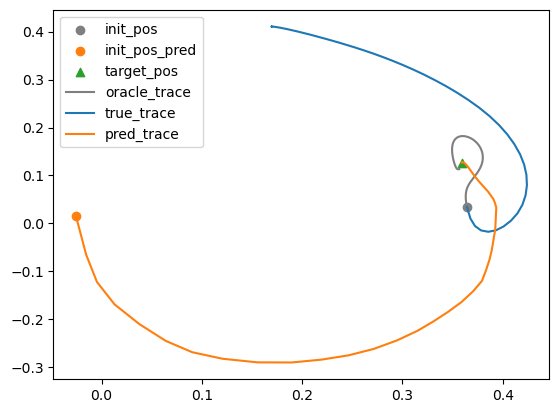

In [188]:
plot_trace(3, 0, 200)
plt.savefig('./img/trace1.png')

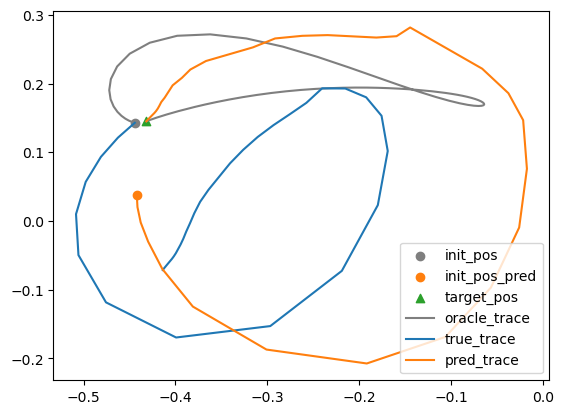

In [189]:
plot_trace(9, 0, 200)
plt.savefig('./img/trace2.png')